In [1]:
%cd ..

c:\Code\Armband


In [2]:
import numpy as np
import random
import os
import keras_tuner as kt
from scipy import signal
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as layers
from tensorflow.keras.layers import GlobalMaxPooling2D, Activation, Dense, Conv1D, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization, GlobalMaxPooling1D
from tensorflow.keras import optimizers

%matplotlib inline
import matplotlib.pyplot as plt

from tensorflow.keras import regularizers



from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from utils.signal import DCFilter, normalize
from utils.visualize import showMe, showHistory, showAvg
from utils.augment import apply_augment

from utils.models.conv_classifier import get_conv_classifier
from utils.models.conv_classifier2 import get_conv_classifier2
from utils.models.dense_classifier import get_dense_classifier
from utils.models.conv_1d import conv_1d
from utils.models.cnn_lstm import cnn_lstm
from utils.models.hyper_conv_classifier import get_hyper_conv_classifier
from utils.data import load_set, pre_process_set, format2train, shuffle

from config.armband import *

%load_ext autoreload
%autoreload 2

In [3]:
sessions = []
for subject in os.listdir(settings['data_path']):
    for session in os.listdir(os.path.join(settings['data_path'],subject)):
        sessions.append(os.path.join(settings['data_path'], subject,session))


val_sessions = ['data\\Nemes\\session_5']#, 'data\\Bence\\session_2']

train_sessions = []
for session in sessions:
    if not session  in val_sessions:
        train_sessions.append(session)


print("-----------   TRAIN SESSION:  ------------------")
print(train_sessions)
print()
print()
print("-----------   VAL SESSIONS:   ------------------")
print(val_sessions)

-----------   TRAIN SESSION:  ------------------
['data\\Bence\\session_2', 'data\\Kristof\\session_1', 'data\\Nemes\\session_0', 'data\\Nemes\\session_1', 'data\\Nemes\\session_2', 'data\\Nemes\\session_3', 'data\\Nemes\\session_4', 'data\\Nemes\\session_6']


-----------   VAL SESSIONS:   ------------------
['data\\Nemes\\session_5']


In [4]:
print("Loading TRAIN SET:")
train_set = load_set(train_sessions)
print()
print()
print("Loading VAL SET:")
val_set = load_set(val_sessions)

Loading TRAIN SET:
Rest: (357, 8, 1000)
Left: (357, 8, 1000)
Right: (357, 8, 1000)
Fist: (357, 8, 1000)


Loading VAL SET:
Rest: (5, 8, 1000)
Left: (5, 8, 1000)
Right: (5, 8, 1000)
Fist: (5, 8, 1000)


In [ ]:
for c in train_set:
    showAvg(train_set,c)

In [5]:
print("PreProcessing TRAIN SET:")
train_pre_processed = pre_process_set(train_set)
print()
print()
print("PreProcessing VAL SET:")
val_pre_processed = pre_process_set(val_set)

PreProcessing TRAIN SET:
Rest: (357, 8, 1000)
Left: (357, 8, 1000)
Right: (357, 8, 1000)
Fist: (357, 8, 1000)


PreProcessing VAL SET:
Rest: (5, 8, 1000)
Left: (5, 8, 1000)
Right: (5, 8, 1000)
Fist: (5, 8, 1000)


In [ ]:
for c in train_pre_processed:
    showAvg(train_pre_processed,c, range = [-1, 1])


In [6]:
print("PreProcessing TRAIN SET:")
train_X, train_y = format2train(train_pre_processed)
print()
print()
print("PreProcessing VAL SET:")
val_X, val_y = format2train(val_pre_processed)

PreProcessing TRAIN SET:
X shape: (1428, 8, 1000)
y shape: (1428, 4)


PreProcessing VAL SET:
X shape: (20, 8, 1000)
y shape: (20, 4)


Class:  Rest


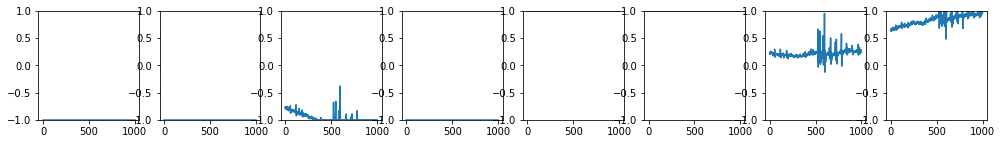

<Figure size 1224x144 with 0 Axes>

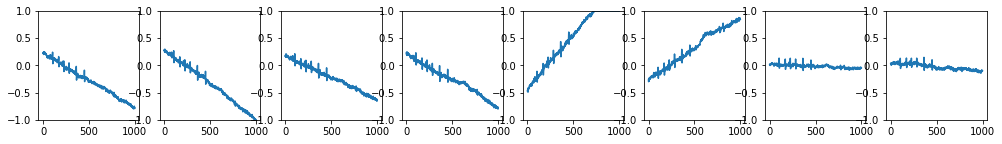

<Figure size 1224x144 with 0 Axes>

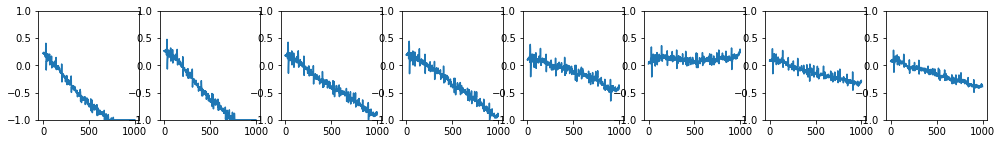

<Figure size 1224x144 with 0 Axes>

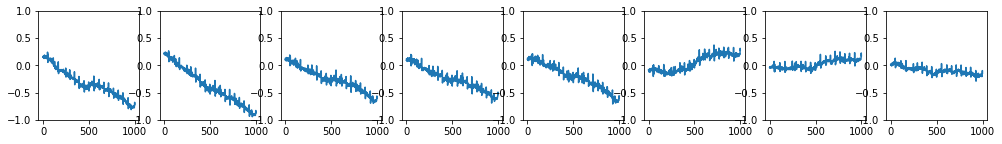

<Figure size 1224x144 with 0 Axes>

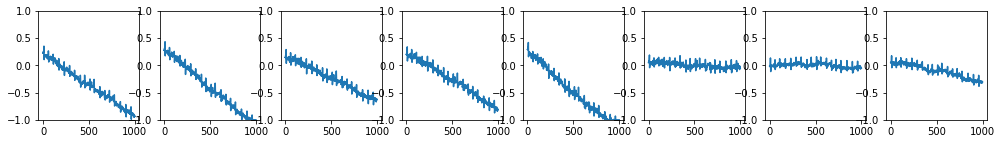

<Figure size 1224x144 with 0 Axes>

Class:  Left


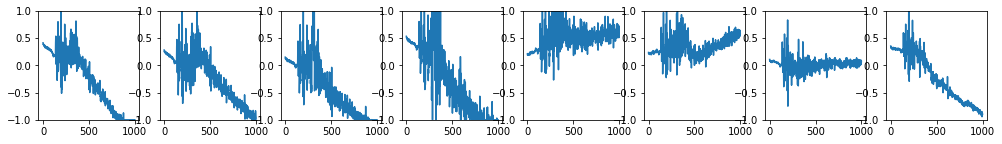

<Figure size 1224x144 with 0 Axes>

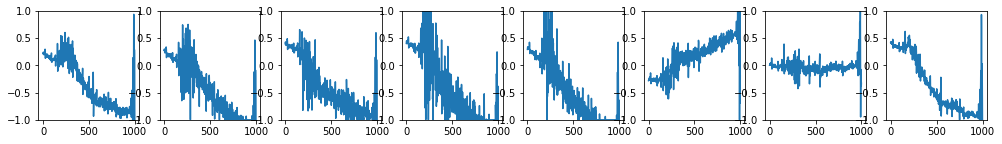

<Figure size 1224x144 with 0 Axes>

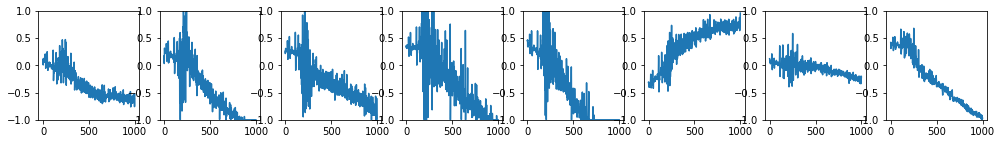

<Figure size 1224x144 with 0 Axes>

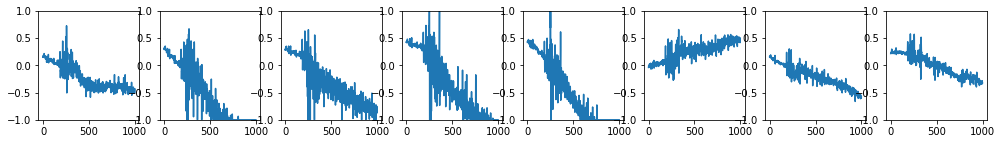

<Figure size 1224x144 with 0 Axes>

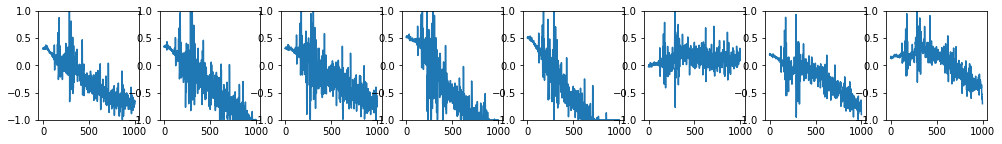

<Figure size 1224x144 with 0 Axes>

Class:  Right


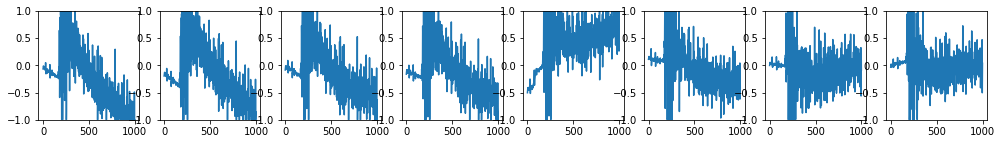

<Figure size 1224x144 with 0 Axes>

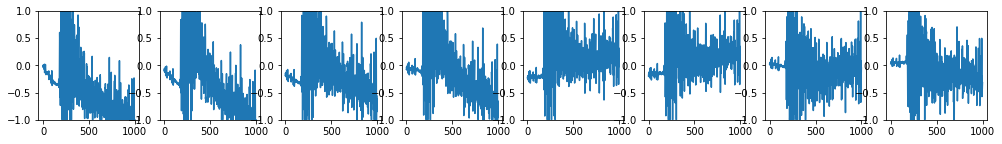

<Figure size 1224x144 with 0 Axes>

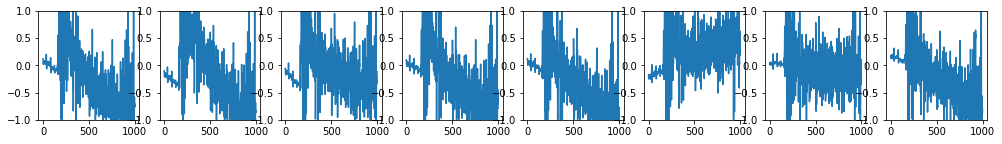

<Figure size 1224x144 with 0 Axes>

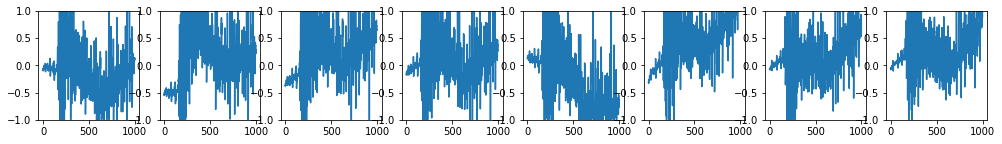

<Figure size 1224x144 with 0 Axes>

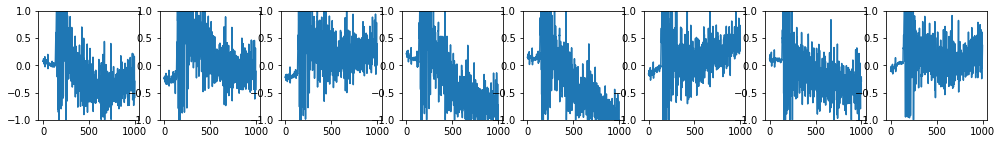

<Figure size 1224x144 with 0 Axes>

Class:  Fist


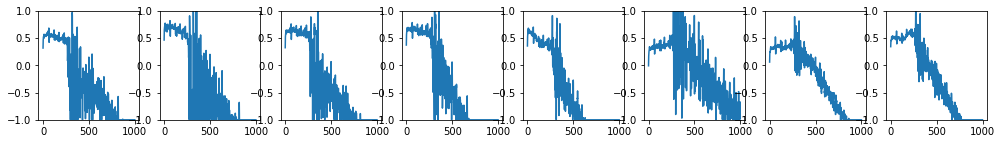

<Figure size 1224x144 with 0 Axes>

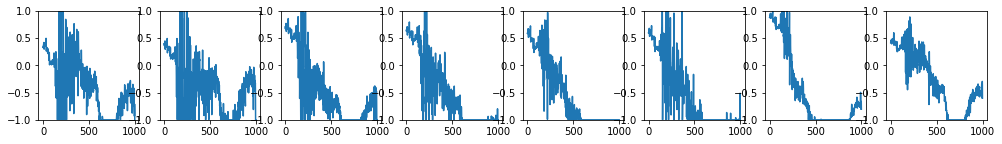

<Figure size 1224x144 with 0 Axes>

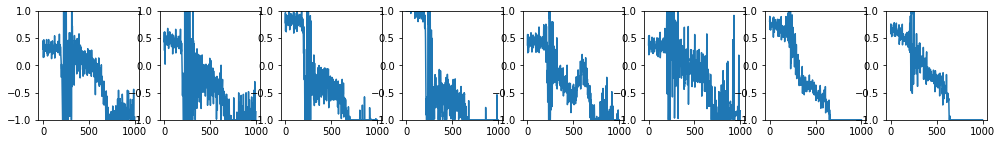

<Figure size 1224x144 with 0 Axes>

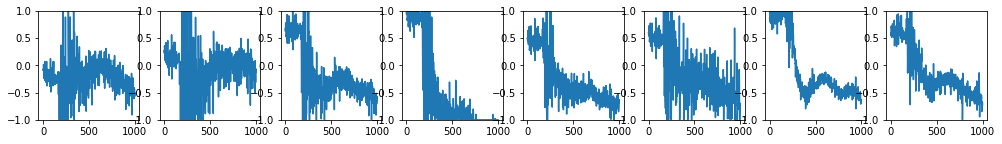

<Figure size 1224x144 with 0 Axes>

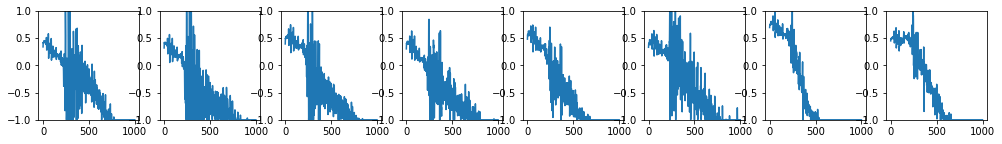

<Figure size 1224x144 with 0 Axes>

In [7]:
for c in settings['classes']:
    print("Class: ", c)
    for i in range(5):
        showMe(train_pre_processed[c][i], range = [-1, 1])

In [ ]:
showMe(train_pre_processed['Rest'][2], range = [-1, 1])

In [8]:
train_X, train_y = apply_augment(train_X, train_y)

In [9]:
train_X, train_y = shuffle(train_X, train_y)

In [10]:
print("Train X:", train_X.shape, 'Train y:', train_y.shape)
print("Val X:", val_X.shape, "Val y:", val_y.shape)

Train X: (4284, 8, 1000) Train y: (4284, 4)
Val X: (20, 8, 1000) Val y: (20, 4)


In [21]:
#model = get_dense_classifier(train_X.shape, train_y.shape)
#model = get_conv_classifier(train_X.shape, train_y.shape)
#model = cnn_lstm(train_X.shape, train_y.shape)

model = conv_1d(train_X.shape, train_y.shape)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-4,
    decay_steps=20,
    decay_rate=0.98
    )
    

opt = keras.optimizers.Adam(learning_rate=lr_schedule)
#opt = keras.optimizers.Adam()

loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=False,
    label_smoothing=0.005,
    name='categorical_crossentropy'
)
model.compile(optimizer=opt,
          loss=loss,
          metrics=['accuracy']
         )

(None, 1000, 8)
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 8, 1000)]         0         
                                                                 
 tf.compat.v1.transpose_5 (T  (None, 1000, 8)          0         
 FOpLambda)                                                      
                                                                 
 conv1d_10 (Conv1D)          (None, 1000, 8)           264       
                                                                 
 batch_normalization_10 (Bat  (None, 1000, 8)          32        
 chNormalization)                                                
                                                                 
 conv1d_11 (Conv1D)          (None, 1000, 16)          528       
                                                                 
 batch_normalization_11 (Bat  (None, 1000, 

Epoch 1/50
17/17 [==============================] - 3s 82ms/step - loss: 1.4069 - accuracy: 0.4104 - val_loss: 1.4229 - val_accuracy: 0.3500
Epoch 2/50
17/17 [==============================] - 1s 53ms/step - loss: 1.1858 - accuracy: 0.5812 - val_loss: 1.3312 - val_accuracy: 0.4500
Epoch 3/50
17/17 [==============================] - 1s 54ms/step - loss: 0.9384 - accuracy: 0.6993 - val_loss: 1.3243 - val_accuracy: 0.3500
Epoch 4/50
17/17 [==============================] - 1s 54ms/step - loss: 0.7290 - accuracy: 0.7687 - val_loss: 1.3388 - val_accuracy: 0.3500
Epoch 5/50
17/17 [==============================] - 1s 54ms/step - loss: 0.5917 - accuracy: 0.8128 - val_loss: 1.3890 - val_accuracy: 0.3000
Epoch 6/50
17/17 [==============================] - 1s 54ms/step - loss: 0.4984 - accuracy: 0.8548 - val_loss: 1.2958 - val_accuracy: 0.3500
Epoch 7/50
17/17 [==============================] - 1s 54ms/step - loss: 0.4348 - accuracy: 0.8889 - val_loss: 1.1513 - val_accuracy: 0.4000
Epoch 8/50
17

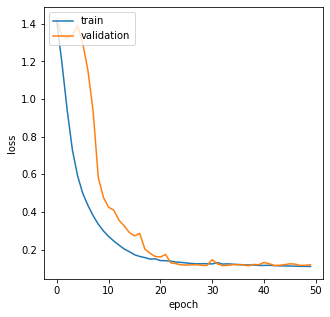

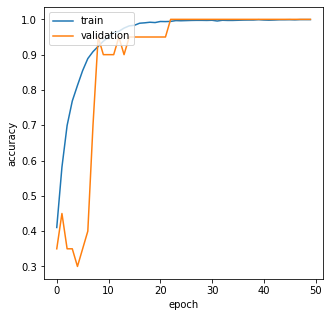

In [22]:
batch_size = 256
history = model.fit(train_X,
                    train_y,
                    validation_data=(val_X, val_y),
                    batch_size=batch_size,
                    epochs=50,
                    shuffle=True)

showHistory(history)          

In [ ]:
model.save('models/nemes_09_06')

In [23]:
val_pred = np.array(model(val_X)).argmax(axis=1)
print(confusion_matrix(val_y.argmax(axis=1), val_pred))
accuracy_score(val_y.argmax(axis=1), val_pred)

[[5 0 0 0]
 [0 5 0 0]
 [0 0 5 0]
 [0 0 0 5]]


1.0

In [38]:
tuner = kt.BayesianOptimization(
    hypermodel = get_hyper_conv_classifier,
    objective = 'val_accuracy',
    max_trials = 400,
    seed = 42,
)


In [39]:
tuner.search(train_X,
            train_y,
            validation_data=(val_X, val_y),
            batch_size= batch_size,
            epochs=100,
            shuffle=True)
tuner.results_summary()

Trial 400 Complete [00h 01m 50s]
val_accuracy: 0.75

Best val_accuracy So Far: 0.8500000238418579
Total elapsed time: 16h 06m 22s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in .\untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
resample: 1
l2: 0.005
pool_1: 100
conv_1: 100
pool_2: 1
conv_2: 50
dense: 50
droupout: 0.1
flatten: 1
lr: 0.01
decay: 0.9
Score: 0.8500000238418579
Trial summary
Hyperparameters:
resample: 1
l2: 0.005
pool_1: 100
conv_1: 50
pool_2: 1
conv_2: 50
dense: 50
droupout: 0.1
flatten: 0
lr: 0.0003069273045576997
decay: 0.9
Score: 0.800000011920929
Trial summary
Hyperparameters:
resample: 1
l2: 0.005
pool_1: 100
conv_1: 100
pool_2: 1
conv_2: 20
dense: 50
droupout: 0.1
flatten: 0
lr: 0.01
decay: 0.9
Score: 0.800000011920929
Trial summary
Hyperparameters:
resample: 1
l2: 0.005
pool_1: 100
conv_1: 100
pool_2: 1
conv_2: 50
dense: 20
droupout: 0.2
flatten: 0
lr: 0.008106668382611886
decay: 0.9
Score: 0.800000011920929
Trial summary
Hype

In [40]:
best_model = tuner.get_best_models()[0]
best_model.save('models/nemes_09_06_tuned')

INFO:tensorflow:Assets written to: models/nemes_09_06_tuned\assets


INFO:tensorflow:Assets written to: models/nemes_09_06_tuned\assets
